# **Loan Default Prediction**
### Machine Learning with Python
---
**Author:** Hai Pham

## 1. Business Problem

Consumer banks generate majority of their profit from lending activity. To boost the bottom line, banks keep increasing their loan to as many customers as possible. The interest income generated from each loan, however, is just a small proportion of loan amount so if a customer default, the bank will incur a huge loss. It is essential for banks to conduct rigorous management of credit risk. 

One approach is to leverage customer data and loan application data to predict if a customer is going to default. With those insights, the bank can decide on approval of loan applicaiton or take appropriate actions to mitigate/prevent loss from customer default. That being said, my project aims to build machine learning models to help banks carry out the prediction.

## 2. Data Loading

First let's import packages necessary for this analysis:

In [1]:
import seaborn as sns

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import math

from matplotlib import pyplot
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, roc_curve, plot_roc_curve, confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier

The dataset is obtained from Kaggle and then uploaded to dropbox so we can load it from a url.

In [2]:
data_url = 'https://www.dropbox.com/s/w2inoxttwprzday/loan_default.csv?dl=1'
dat = pd.read_csv(data_url, na_values=np.NaN)

In [3]:
# Get a general information of the data set
dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 27 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   SK_ID_CURR                  307511 non-null  int64  
 1   TARGET                      307511 non-null  int64  
 2   NAME_CONTRACT_TYPE          307511 non-null  object 
 3   CODE_GENDER                 307511 non-null  object 
 4   FLAG_OWN_CAR                307511 non-null  object 
 5   FLAG_OWN_REALTY             307511 non-null  object 
 6   CNT_CHILDREN                307511 non-null  int64  
 7   AMT_INCOME_TOTAL            307511 non-null  float64
 8   AMT_CREDIT                  307511 non-null  float64
 9   NAME_TYPE_SUITE             306219 non-null  object 
 10  NAME_INCOME_TYPE            307511 non-null  object 
 11  NAME_EDUCATION_TYPE         307511 non-null  object 
 12  NAME_FAMILY_STATUS          307511 non-null  object 
 13  NAME_HOUSING_T

In [4]:
# Take a look at the first 5 rows
dat.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,NAME_TYPE_SUITE,...,FLAG_EMP_PHONE,FLAG_CONT_MOBILE,OCCUPATION_TYPE,REGION_RATING_CLIENT,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,ORGANIZATION_TYPE,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,Unaccompanied,...,1,1,Laborers,2,WEDNESDAY,10,0,Business Entity Type 3,2.0,2.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,Family,...,1,1,Core staff,1,MONDAY,11,0,School,1.0,1.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,Unaccompanied,...,1,1,Laborers,2,MONDAY,9,0,Government,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,Unaccompanied,...,1,1,Laborers,2,WEDNESDAY,17,0,Business Entity Type 3,2.0,2.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,Unaccompanied,...,1,1,Core staff,2,THURSDAY,11,0,Religion,0.0,0.0


The dataset for this project, available on Kaggle, contains loan applicants' data of a bank. The dataset include `307,511` instances, each of which represents an application. There are `27` variables, `26` of which are predictors and `1` label specifying whether a customer defaults.

Predictors:
1. `SK_ID_CURR`: ID of loan
2. `NAME_CONTRACT_TYPE`: is the loan cash or revolving?
3. `CODE_GENDER`: gender of the customer
4. `FLAG_OWN_CAR`: whether the customer owns a car
5. `FLAG_OWN_REALTY`: whether the customer owns a house or flat
6. `CNT_CHILDREN`: number of childen the customer has
7. `AMT_INCOME_TOTAL`: annual income of the customer
8. `AMT_CREDIT`: amount of the loan
9. `NAME_TYPE_SUITE`: who was accompanying customer when she/he applied for the loan?
10. `NAME_INCOME_TYPE`: customer's income type (e.g. Working, State servant,...)
11. `NAME_EDUCATION_TYPE`: highest level of education the client achieved
12. `NAME_FAMILY_STATUS`: family status of customer (e.g. Single, Married,...)
13. `NAME_HOUSING_TYPE`: housing situation of client (rented apartment, living with parents,...)
14. `DAYS_EMPLOYED`: how many days before the application did the customer start her current employent?
15. `DAYS_ID_PUBLISH`: how many days before the application did the customer change the identity document?
16. `FLAG_MOBIL`: did the customer provide mobile phone number? 1 = yes, 0 = no
17. `FLAG_EMP_PHONE`: did the customer provide work phone number? 1 = yes, 0 = no
18. `FLAG_CONT_MOBILE`: was customer's mobile phone reachable? 1 = yes, 0 = no
19. `OCCUPATION_TYPE`: what kind of occupation is the customer having?
20. `REGION_RATING_CLIENT`: rating of the region where the customer is living
21. `WEEKDAY_APPR_PROCESS_START`: on which day of the week did the customer apply for the loan
22. `HOUR_APPR_PROCESS_START`: at what hour did the customer apply for the loan
23. `REG_REGION_NOT_LIVE_REGION`: does customer's permanent address match contact address she provided? 1 = yes, 0 = no
24. `ORGANIZATION_TYPE`: type of organization where customer works
25. `OBS_30_CNT_SOCIAL_CIRCLE`: how many observations of customer's social surroundings incurred 30 DPD (days past due) default
26. `OBS_60_CNT_SOCIAL_CIRCLE`: how many observations of customer's social surroundings incurred 60 DPD (days past due) default

Target variable: 

27. `TARGET`: has the customer defaulted? binary variable: 1 = yes, 0 = no

It is obvious that `SK_ID_CURR` has no predictive power so it should be removed from the dataset. Also, let's change the values of 1 and 0 to yes and no to make the visualization more interpretable.

In [5]:
dat.drop('SK_ID_CURR', axis =1, inplace = True)
dat.TARGET.replace(1, 'yes', inplace = True)
dat.TARGET.replace(0, 'no', inplace = True)
dat.FLAG_MOBIL.replace(1, 'yes', inplace = True)
dat.FLAG_MOBIL.replace(0, 'no', inplace = True)
dat.FLAG_EMP_PHONE.replace(1, 'yes', inplace = True)
dat.FLAG_EMP_PHONE.replace(0, 'no', inplace = True)
dat.FLAG_CONT_MOBILE.replace(1, 'yes', inplace = True)
dat.FLAG_CONT_MOBILE.replace(0, 'no', inplace = True)
dat.REG_REGION_NOT_LIVE_REGION.replace(1, 'yes', inplace = True)
dat.REG_REGION_NOT_LIVE_REGION.replace(0, 'no', inplace = True)

In [6]:
# Take a look at the first five rows again
dat.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,NAME_TYPE_SUITE,NAME_INCOME_TYPE,...,FLAG_EMP_PHONE,FLAG_CONT_MOBILE,OCCUPATION_TYPE,REGION_RATING_CLIENT,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,ORGANIZATION_TYPE,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE
0,yes,Cash loans,M,N,Y,0,202500.0,406597.5,Unaccompanied,Working,...,yes,yes,Laborers,2,WEDNESDAY,10,no,Business Entity Type 3,2.0,2.0
1,no,Cash loans,F,N,N,0,270000.0,1293502.5,Family,State servant,...,yes,yes,Core staff,1,MONDAY,11,no,School,1.0,1.0
2,no,Revolving loans,M,Y,Y,0,67500.0,135000.0,Unaccompanied,Working,...,yes,yes,Laborers,2,MONDAY,9,no,Government,0.0,0.0
3,no,Cash loans,F,N,Y,0,135000.0,312682.5,Unaccompanied,Working,...,yes,yes,Laborers,2,WEDNESDAY,17,no,Business Entity Type 3,2.0,2.0
4,no,Cash loans,M,N,Y,0,121500.0,513000.0,Unaccompanied,Working,...,yes,yes,Core staff,2,THURSDAY,11,no,Religion,0.0,0.0


---

## 3. Descriptive Analysis

Now that we have fetched the data, let's conduct descriptive analysis by plotting visualization. We can start with the distribution of `TARGET` variable

<AxesSubplot:xlabel='TARGET', ylabel='count'>

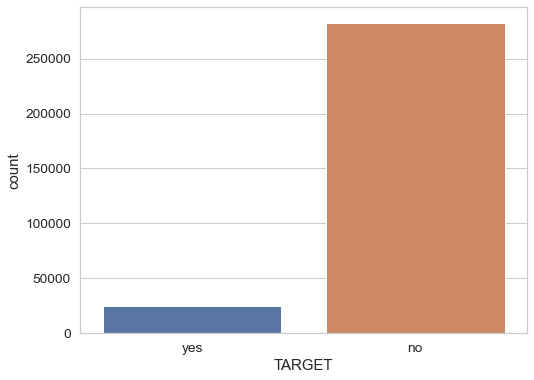

In [7]:
sns.set(rc = {'figure.figsize': (8, 6)},
        font_scale = 1.25) 
sns.set_style('whitegrid')

sns.countplot(x = 'TARGET',
              data = dat)

This target class is extremely skewed with nearly 280,000 no and only around 25,000 yes. This is intuitive as we often have more customers paying loan by due data than customers defaulting.  

Let's continue exploring relationships between target variable and other predictors to get a sense of their impacts on the default probability

<AxesSubplot:xlabel='REGION_RATING_CLIENT', ylabel='count'>

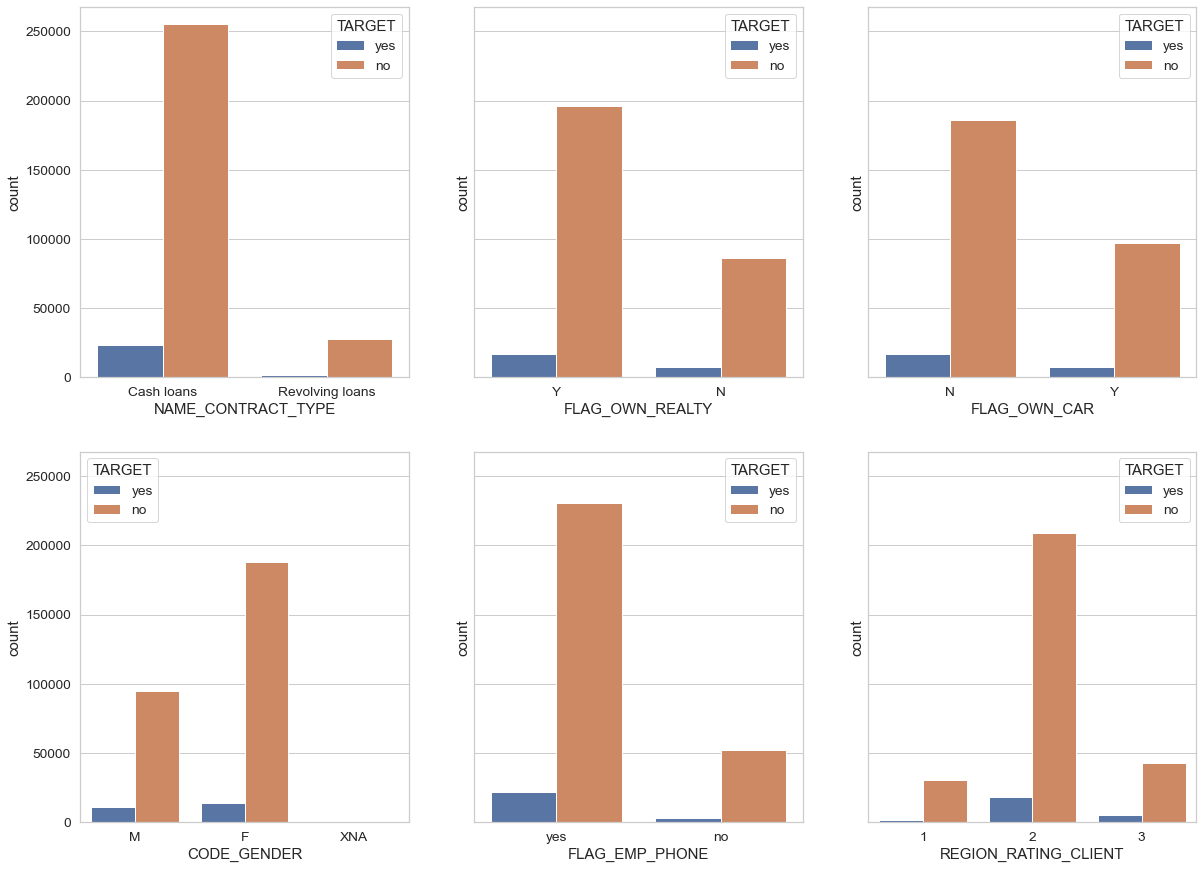

In [8]:
fig, axes = plt.subplots(2, 3, figsize=(20, 15), sharey=True)

sns.countplot(ax = axes[0, 0],
              x = 'NAME_CONTRACT_TYPE',
              hue =  'TARGET',
              data = dat)

sns.countplot(ax = axes[0, 1],
              x = 'FLAG_OWN_REALTY',
              hue =  'TARGET',
              data = dat)

sns.countplot(ax = axes[0, 2],
              x = 'FLAG_OWN_CAR',
              hue =  'TARGET',
              data = dat)

sns.countplot(ax = axes[1, 0],
              x = 'CODE_GENDER',
              hue =  'TARGET',
              data = dat)

sns.countplot(ax = axes[1, 1],
              x = 'FLAG_EMP_PHONE',
              hue =  'TARGET',
              data = dat)

sns.countplot(ax = axes[1, 2],
              x = 'REGION_RATING_CLIENT',
              hue =  'TARGET',
              data = dat)

Based on the above charts, we can see that customers that are more likely to default have the following characteristics:

- apply for cash loans
- own a house/flat
- don't own a car
- provide work phone
- live in region rated 2 by bank system

[Text(0, 0, 'Secondary / secondary special'),
 Text(1, 0, 'Higher education'),
 Text(2, 0, 'Incomplete higher'),
 Text(3, 0, 'Lower secondary'),
 Text(4, 0, 'Academic degree')]

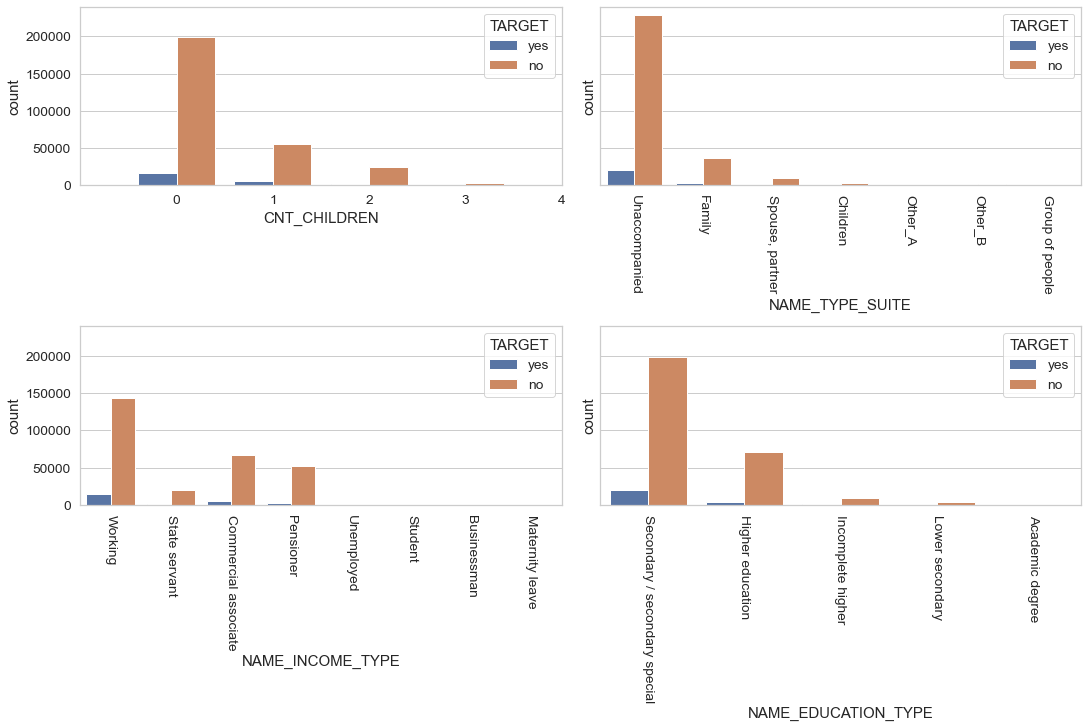

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharey=True, constrained_layout=True)

sns.countplot(ax = axes[0, 0],
              x = 'CNT_CHILDREN',
              hue =  'TARGET',
              data = dat)
axes[0,0].set_xlim(-1,4)


sns.countplot(ax = axes[0, 1],
              x = 'NAME_TYPE_SUITE',
              hue =  'TARGET',
              data = dat)
axes[0,1].set_xticklabels(axes[0,1].get_xticklabels(),rotation=270)


sns.countplot(ax = axes[1, 0],
              x = 'NAME_INCOME_TYPE',
              hue =  'TARGET',
              data = dat)
axes[1,0].set_xticklabels(axes[1,0].get_xticklabels(),rotation=270)


sns.countplot(ax = axes[1, 1],
              x = 'NAME_EDUCATION_TYPE',
              hue =  'TARGET',
              data = dat)
axes[1,1].set_xticklabels(axes[1,1].get_xticklabels(),rotation=270)

Based on the above charts, we can see that customers that are more likely to default have the following characteristics:

- have no children
- have nobody accompany when she/he applied for the loan
- have income type of working
- have secondary as the highest level of education

(-4500.0, -1500.0)

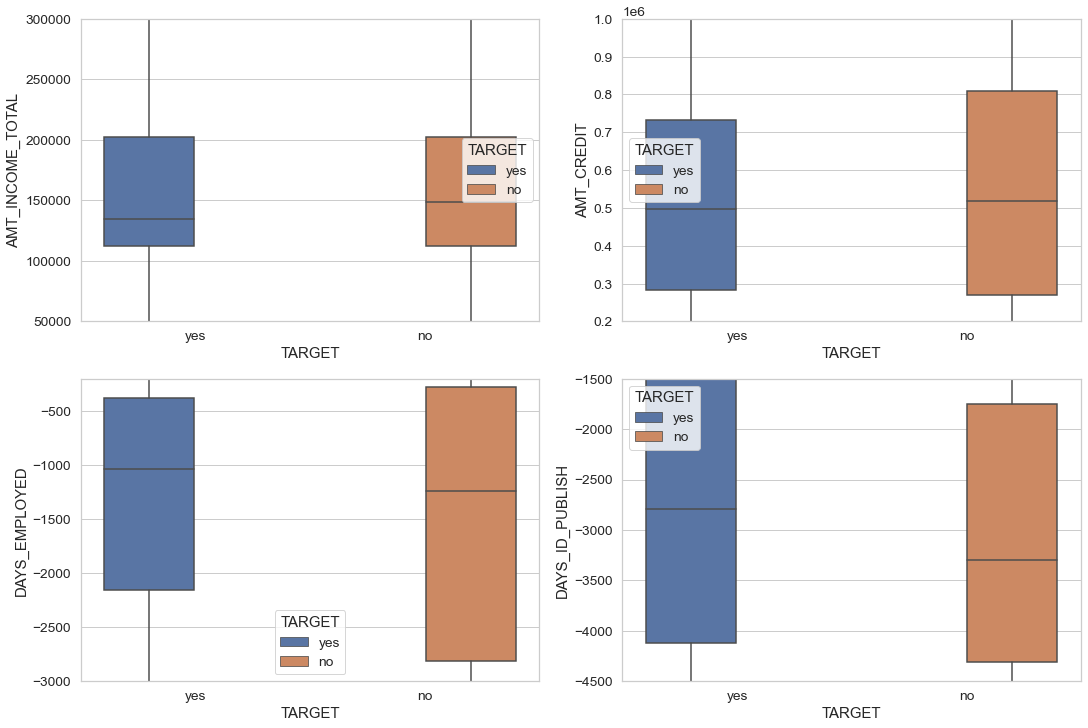

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharey=False, constrained_layout=True)

sns.boxplot(ax = axes[0, 0],
              x = 'TARGET',
              y = 'AMT_INCOME_TOTAL',
              hue =  'TARGET',
              data = dat)
axes[0,0].set_ylim(50000,300000)

sns.boxplot(ax = axes[0, 1],
              x = 'TARGET',
              y = 'AMT_CREDIT',
              hue =  'TARGET',
              data = dat)
axes[0,1].set_ylim(200000,1000000)

sns.boxplot(ax = axes[1, 0],
              x = 'TARGET',
              y = 'DAYS_EMPLOYED',
              hue =  'TARGET',
              data = dat)
axes[1,0].set_ylim(-3000,-200)

sns.boxplot(ax = axes[1, 1],
              x = 'TARGET',
              y = 'DAYS_ID_PUBLISH',
              hue =  'TARGET',
              data = dat)
axes[1,1].set_ylim(-4500,-1500)

Based on the above charts, we can see that customers that are more likely to default have the following characteristics:

- have lower total income
- have lower days of employment of current jobs
- changed their identity shortly before loan application

---

## 4. Machine Learning

In the previous section, we get a sense of which features have more impact on the default probability. Now let's train multiple machine learning models using as many meaningful predictors as available in an effort to find the optimal predictive model. This model would be used to predict whether a new customer defaults given that applicant's data. 

Prior to model fitting, we need to conduct data preprocessing which includes train and test set split, class balancing, handling of missing values, categorical variable conversion, removal zero-variance features, and feature scaling.

## 4.1. Data preprocessing

### Train and test set split

First let's split our dataset into training set with 80% of instances and test set of 20% instances. The training set will be used to train the model and the test set will be used to evaluate models' generalization performance.

In [11]:
Train, Test = train_test_split(dat, 
                               stratify = dat.TARGET,
                               test_size = 0.20, 
                               random_state = 234)

### Class balancing

The previous visualization shows that there's class imbalance in original dataset so we need to check issue in the training set as well.

In [12]:
display(Train.groupby('TARGET').size(),
round(Train.groupby('TARGET').size()/len(Train), 3))

TARGET
no     226148
yes     19860
dtype: int64

TARGET
no     0.919
yes    0.081
dtype: float64

This target class is extremely skewed with 92% no and just 8% yes, posing a challenge for predictive modeling since most machine learning algorithms assume an equal number of instances for each class. Let's resolve this issue by downsampling the majority class (i.e. no) in the training data:

In [13]:
np.random.seed(234)

major_class = np.where(Train.TARGET == 'no')[0]
minor_class = np.where(Train.TARGET == 'yes')[0]

resample = np.random.choice(major_class, size = len(minor_class), replace = False)

TrainDS = pd.concat([Train.iloc[minor_class], Train.iloc[resample]])

TrainDS.shape

(39720, 26)

Check the output again to make sure we are having a balance class:

In [14]:
display(TrainDS.groupby('TARGET').size())
round(TrainDS.groupby('TARGET').size()/len(TrainDS), 2)

TARGET
no     19860
yes    19860
dtype: int64

TARGET
no     0.5
yes    0.5
dtype: float64

### Handling missing values

Next let's check missing values in the training set to take care of them since some machine learning models can't handle missing values:

In [15]:
TrainDS.isna().sum()

TARGET                            0
NAME_CONTRACT_TYPE                0
CODE_GENDER                       0
FLAG_OWN_CAR                      0
FLAG_OWN_REALTY                   0
CNT_CHILDREN                      0
AMT_INCOME_TOTAL                  0
AMT_CREDIT                        0
NAME_TYPE_SUITE                 133
NAME_INCOME_TYPE                  0
NAME_EDUCATION_TYPE               0
NAME_FAMILY_STATUS                0
NAME_HOUSING_TYPE                 0
DAYS_EMPLOYED                     0
DAYS_ID_PUBLISH                   0
FLAG_MOBIL                        0
FLAG_EMP_PHONE                    0
FLAG_CONT_MOBILE                  0
OCCUPATION_TYPE               11441
REGION_RATING_CLIENT              0
WEEKDAY_APPR_PROCESS_START        0
HOUR_APPR_PROCESS_START           0
REG_REGION_NOT_LIVE_REGION        0
ORGANIZATION_TYPE                 0
OBS_30_CNT_SOCIAL_CIRCLE         85
OBS_60_CNT_SOCIAL_CIRCLE         85
dtype: int64

As we can see, missing data exist in the the following features: `NAME_TYPE_SUITE`, `OCCUPATION_TYPE`, `OBS_30_CNT_SOCIAL_CIRCLE`, `OBS_60_CNT_SOCIAL_CIRCLE`. We can impute the missing data using the most frequent value for categorical variables and using the median for numerical variables.

In [16]:
imp_median = SimpleImputer(missing_values = np.nan, strategy = 'median')

imp_raw_data_train = TrainDS.drop(columns = 'TARGET').select_dtypes(exclude = ['object', 'category'])

imp_median = imp_median.fit(imp_raw_data_train)

imputed_data_train = pd.DataFrame(imp_median.transform(imp_raw_data_train))

imputed_data_train.columns = imp_raw_data_train.columns
imputed_data_train.index = imp_raw_data_train.index

TrainDS_Imp = pd.concat([TrainDS.drop(imp_raw_data_train.columns, axis = 1), imputed_data_train], axis = 1)

In [17]:
imp_frequent = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')

imp_raw_data_train = TrainDS_Imp.drop(columns = 'TARGET').select_dtypes(include = ['object', 'category'])

imp_frequent = imp_frequent.fit(imp_raw_data_train)

imputed_data_train = pd.DataFrame(imp_frequent.transform(imp_raw_data_train))

imputed_data_train.columns = imp_raw_data_train.columns
imputed_data_train.index = imp_raw_data_train.index

TrainDS_Imp = pd.concat([TrainDS_Imp.drop(imp_raw_data_train.columns, axis = 1), imputed_data_train], axis = 1)

TrainDS_Imp.head()

,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,DAYS_EMPLOYED,DAYS_ID_PUBLISH,REGION_RATING_CLIENT,HOUR_APPR_PROCESS_START,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,...,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_CONT_MOBILE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,ORGANIZATION_TYPE
76992,yes,3.0,76500.0,343800.0,-441.0,-753.0,2.0,9.0,0.0,0.0,...,Secondary / secondary special,Married,House / apartment,yes,yes,yes,Laborers,TUESDAY,no,Business Entity Type 1
183486,yes,2.0,67500.0,227520.0,-509.0,-2888.0,2.0,6.0,0.0,0.0,...,Secondary / secondary special,Married,House / apartment,yes,yes,yes,Low-skill Laborers,SATURDAY,no,Business Entity Type 3
194812,yes,3.0,675000.0,1157670.0,-4373.0,-4565.0,2.0,17.0,1.0,1.0,...,Secondary / secondary special,Married,House / apartment,yes,yes,yes,Managers,WEDNESDAY,no,Trade: type 7
21842,yes,0.0,202500.0,360000.0,-930.0,-1763.0,2.0,15.0,2.0,2.0,...,Higher education,Married,House / apartment,yes,yes,yes,Laborers,THURSDAY,no,Services
172513,yes,0.0,292500.0,835380.0,-454.0,-4512.0,2.0,13.0,0.0,0.0,...,Secondary / secondary special,Married,House / apartment,yes,yes,yes,Laborers,MONDAY,no,Business Entity Type 3


Check the missing values again to ensure no missing data in the imputed training set.

In [18]:
TrainDS_Imp.isna().sum()

TARGET                        0
CNT_CHILDREN                  0
AMT_INCOME_TOTAL              0
AMT_CREDIT                    0
DAYS_EMPLOYED                 0
DAYS_ID_PUBLISH               0
REGION_RATING_CLIENT          0
HOUR_APPR_PROCESS_START       0
OBS_30_CNT_SOCIAL_CIRCLE      0
OBS_60_CNT_SOCIAL_CIRCLE      0
NAME_CONTRACT_TYPE            0
CODE_GENDER                   0
FLAG_OWN_CAR                  0
FLAG_OWN_REALTY               0
NAME_TYPE_SUITE               0
NAME_INCOME_TYPE              0
NAME_EDUCATION_TYPE           0
NAME_FAMILY_STATUS            0
NAME_HOUSING_TYPE             0
FLAG_MOBIL                    0
FLAG_EMP_PHONE                0
FLAG_CONT_MOBILE              0
OCCUPATION_TYPE               0
WEEKDAY_APPR_PROCESS_START    0
REG_REGION_NOT_LIVE_REGION    0
ORGANIZATION_TYPE             0
dtype: int64

### Converting categorical variables to dummy attributes

Now we need to convert categorical variables to dummy variables by using one hot encoding from `sklearn` package.

In [19]:
enc = OneHotEncoder(handle_unknown = 'ignore', sparse = False)

enc_raw_data_train = TrainDS_Imp.drop(columns = 'TARGET').select_dtypes(include = ['object', 'category'])

enc = enc.fit(enc_raw_data_train)

encoded_data_train = pd.DataFrame(enc.transform(enc_raw_data_train))

encoded_data_train.columns = enc.get_feature_names(enc_raw_data_train.columns)
encoded_data_train.index = enc_raw_data_train.index

TrainDS_ImpEnc = pd.concat([TrainDS_Imp.drop(enc_raw_data_train.columns, axis = 1), encoded_data_train], axis = 1)

TrainDS_ImpEnc.head()

,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,DAYS_EMPLOYED,DAYS_ID_PUBLISH,REGION_RATING_CLIENT,HOUR_APPR_PROCESS_START,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,...,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA
76992,yes,3.0,76500.0,343800.0,-441.0,-753.0,2.0,9.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
183486,yes,2.0,67500.0,227520.0,-509.0,-2888.0,2.0,6.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
194812,yes,3.0,675000.0,1157670.0,-4373.0,-4565.0,2.0,17.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
21842,yes,0.0,202500.0,360000.0,-930.0,-1763.0,2.0,15.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
172513,yes,0.0,292500.0,835380.0,-454.0,-4512.0,2.0,13.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Removing zero-variance features

Features with zero variance have almost no predictive power so let's remove them using a variance threshold approach.

In [20]:
selector = VarianceThreshold()

sel_raw_data_train = TrainDS_ImpEnc.drop(columns = 'TARGET')

selector = selector.fit(sel_raw_data_train)

selected_data_train = sel_raw_data_train.iloc[:, selector.get_support(indices = True)]

TrainDS_ImpEncSel = pd.concat([TrainDS_ImpEnc.drop(sel_raw_data_train.columns, axis = 1), selected_data_train], axis = 1)

TrainDS_ImpEncSel.head()

,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,DAYS_EMPLOYED,DAYS_ID_PUBLISH,REGION_RATING_CLIENT,HOUR_APPR_PROCESS_START,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,...,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA
76992,yes,3.0,76500.0,343800.0,-441.0,-753.0,2.0,9.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
183486,yes,2.0,67500.0,227520.0,-509.0,-2888.0,2.0,6.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
194812,yes,3.0,675000.0,1157670.0,-4373.0,-4565.0,2.0,17.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
21842,yes,0.0,202500.0,360000.0,-930.0,-1763.0,2.0,15.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
172513,yes,0.0,292500.0,835380.0,-454.0,-4512.0,2.0,13.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The number of features decreases by one after running the `VarianceThreshold()`.

### Scaling features

Machine Learning algorithms don't perform well when the input numberical features have very different scales. They make assumption that high ranging numbers have more predictive power than low ranging numbers. Let's mitigate this issue by leveraging Robust Scaler from `sklearn` to scale our numerical features.

In [21]:
scaler = RobustScaler()

sca_raw_data_train = TrainDS_ImpEncSel.drop(columns = 'TARGET').select_dtypes(exclude = ['object', 'category'])

scaler = scaler.fit(sca_raw_data_train)

scaled_data_train = pd.DataFrame(scaler.transform(sca_raw_data_train))

scaled_data_train.columns = sca_raw_data_train.columns
scaled_data_train.index = sca_raw_data_train.index

TrainDS_ImpEncSelSca = pd.concat([TrainDS_ImpEncSel.drop(sca_raw_data_train.columns, axis = 1), scaled_data_train], axis = 1)

TrainDS_ImpEncSelSca.head()

,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,DAYS_EMPLOYED,DAYS_ID_PUBLISH,REGION_RATING_CLIENT,HOUR_APPR_PROCESS_START,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,...,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA
76992,yes,3.0,-0.70,-0.326809,0.319053,0.863961,0.0,-0.75,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
183486,yes,2.0,-0.80,-0.557546,0.287472,0.061631,0.0,-1.50,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
194812,yes,3.0,5.95,1.288171,-1.507024,-0.568583,0.0,1.25,0.5,0.5,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
21842,yes,0.0,0.70,-0.294663,0.091954,0.484404,0.0,0.75,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
172513,yes,0.0,1.70,0.648644,0.313015,-0.548666,0.0,0.25,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Pre-processing test set

Those are all pre-processing steps for training set. Now we need to apply all of what we performed earlier to the test set as well so we can evaluate models' generalization performance. In order to avoid ***data leakage***, we need to pre-process test set using values from training set.

In [22]:
# Take a look at the first 5 rows of test set
Test.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,NAME_TYPE_SUITE,NAME_INCOME_TYPE,...,FLAG_EMP_PHONE,FLAG_CONT_MOBILE,OCCUPATION_TYPE,REGION_RATING_CLIENT,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,ORGANIZATION_TYPE,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE
77687,no,Cash loans,F,N,N,0,247500.0,1170000.0,Unaccompanied,Working,...,yes,yes,NaN,2,WEDNESDAY,10,no,Business Entity Type 3,0.0,0.0
240570,no,Cash loans,F,Y,Y,1,90000.0,168102.0,Unaccompanied,State servant,...,yes,yes,NaN,2,FRIDAY,9,no,Government,0.0,0.0
277115,no,Cash loans,F,Y,Y,1,450000.0,1066320.0,Unaccompanied,Commercial associate,...,yes,yes,Core staff,1,MONDAY,15,no,Kindergarten,0.0,0.0
289423,no,Cash loans,M,N,Y,0,126000.0,360000.0,Unaccompanied,Working,...,yes,yes,Sales staff,2,TUESDAY,13,no,Business Entity Type 3,0.0,0.0
97111,no,Cash loans,F,N,Y,0,112500.0,585000.0,Unaccompanied,Pensioner,...,no,yes,NaN,2,WEDNESDAY,13,no,XNA,4.0,4.0


In [23]:
Test.isna().sum()

TARGET                            0
NAME_CONTRACT_TYPE                0
CODE_GENDER                       0
FLAG_OWN_CAR                      0
FLAG_OWN_REALTY                   0
CNT_CHILDREN                      0
AMT_INCOME_TOTAL                  0
AMT_CREDIT                        0
NAME_TYPE_SUITE                 270
NAME_INCOME_TYPE                  0
NAME_EDUCATION_TYPE               0
NAME_FAMILY_STATUS                0
NAME_HOUSING_TYPE                 0
DAYS_EMPLOYED                     0
DAYS_ID_PUBLISH                   0
FLAG_MOBIL                        0
FLAG_EMP_PHONE                    0
FLAG_CONT_MOBILE                  0
OCCUPATION_TYPE               19215
REGION_RATING_CLIENT              0
WEEKDAY_APPR_PROCESS_START        0
HOUR_APPR_PROCESS_START           0
REG_REGION_NOT_LIVE_REGION        0
ORGANIZATION_TYPE                 0
OBS_30_CNT_SOCIAL_CIRCLE        201
OBS_60_CNT_SOCIAL_CIRCLE        201
dtype: int64

In [24]:
# Handling missing values: median imputation for numeric data
imp_raw_data_test = Test.drop(columns = 'TARGET').select_dtypes(exclude = ['object', 'category'])

imputed_data_test = pd.DataFrame(imp_median.transform(imp_raw_data_test))

imputed_data_test.columns = imp_raw_data_test.columns
imputed_data_test.index = imp_raw_data_test.index

Test_Imp = pd.concat([Test.drop(imp_raw_data_test.columns, axis = 1), imputed_data_test], axis = 1)



# Handling missing values: most frequent imputation for categorical data
imp_raw_data_test = Test_Imp.drop(columns = 'TARGET').select_dtypes(include = ['object', 'category'])

imputed_data_test = pd.DataFrame(imp_frequent.transform(imp_raw_data_test))

imputed_data_test.columns = imp_raw_data_test.columns
imputed_data_test.index = imp_raw_data_test.index

Test_Imp = pd.concat([Test_Imp.drop(imp_raw_data_test.columns, axis = 1), imputed_data_test], axis = 1)



# Converting categorical variables to dummy attributes
enc_raw_data_test = Test_Imp.drop(columns = 'TARGET').select_dtypes(include = ['object', 'category'])

encoded_data_test = pd.DataFrame(enc.transform(enc_raw_data_test))

encoded_data_test.columns = enc.get_feature_names(enc_raw_data_test.columns)
encoded_data_test.index = enc_raw_data_test.index

Test_ImpEnc = pd.concat([Test_Imp.drop(enc_raw_data_test.columns, axis = 1), encoded_data_test], axis = 1)



# Removing zero-variance features
sel_raw_data_test = Test_ImpEnc.drop(columns = 'TARGET')

selected_data_test = sel_raw_data_test.iloc[:, selector.get_support(indices = True)]

Test_ImpEncSel = pd.concat([Test_ImpEnc.drop(sel_raw_data_train.columns, axis = 1), selected_data_test], axis = 1)



# Scaling features
sca_raw_data_test = Test_ImpEncSel.drop(columns = 'TARGET')

scaled_data_test = pd.DataFrame(scaler.transform(sca_raw_data_test))

scaled_data_test.columns = sca_raw_data_test.columns
scaled_data_test.index = sca_raw_data_test.index

Test_ImpEncSelSca = pd.concat([Test_ImpEncSel.drop(sca_raw_data_test.columns, axis = 1), scaled_data_test], axis = 1)

# Take a look at our final test set
Test_ImpEncSelSca.head()

,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,DAYS_EMPLOYED,DAYS_ID_PUBLISH,REGION_RATING_CLIENT,HOUR_APPR_PROCESS_START,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,...,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA
77687,no,0.0,1.20,1.312638,0.191803,-0.026306,0.0,-0.50,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
240570,no,1.0,-0.55,-0.675450,-0.013004,0.933484,0.0,-0.75,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
277115,no,1.0,3.45,1.106903,0.281899,0.829387,-1.0,0.75,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
289423,no,0.0,-0.15,-0.294663,0.233136,0.431041,0.0,0.25,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97111,no,0.0,-0.30,0.151810,170.147916,-0.234123,0.0,0.25,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## 4.2. Model training and evaluation

Now that we completed data pre-processing steps for both train and test sets. Now let's train several machine learning models and fine-tune them to find the optimal predictive model. We are going to fit the following classifers:

1. Logistic Regression
2. Decision Tree
3. Random Forest
4. AdaBoost
5. XGBoost

We will leverage ***grid search*** approach that involves sequentally evaluating hyperparameter combinations to find the optima in each type of classifier. Specifically, we will be using the ***GridSearchCV*** function  in `sklearn` package, which uses ***cross-validation*** to exhaustively evaluate different settings from a set of pre-defined options. After testing all of the parameter combinations, it will ultimately find and utilize the setting with the best predictive performance based on a selected ***evaluation metrics*** (i.e. balanced accuracy is used in this case) to train the classifers on the whole training set.

In [25]:
# Set up data and labels with respect to both training and test set
X_train = TrainDS_ImpEncSelSca.drop(columns = 'TARGET')
y_train = TrainDS_ImpEncSelSca.TARGET

X_test = Test_ImpEncSelSca.drop(columns = 'TARGET')
y_test = Test_ImpEncSelSca.TARGET

pos_label = 'yes'

# Set up scoring metric
scoring_metric = 'balanced_accuracy'

# Set up classifiers and tuning parameters
names = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'AdaBoost', 'XGBoost']
classifiers = [LogisticRegression(random_state = 234, solver = 'saga', max_iter = 10000),
               DecisionTreeClassifier(random_state = 234), 
               RandomForestClassifier(random_state = 234), 
               AdaBoostClassifier(random_state = 234),
               XGBClassifier(random_state = 234)]
param_grids = [{'penalty': ['l1', 'l2']},
               {'max_depth': [2, 3, 4, 5, 10, 15], 'criterion': ['gini', 'entropy']},
               {'max_depth': [3, 4, 5, 6], 'max_features': [None, 'sqrt', 'log2'], 'n_estimators': [50, 100, 200]},
               {'n_estimators': [50, 100, 200]},
               {'n_estimators': [50, 100, 200]}]

# Create empty lists for storing outcomes
models = []
preds = []
probs = []
BAs = []
AUCs = []
FPRs = []
TPRs = []
timings = []

# Train classifiers and generate test predictions/probabilities
for i, eachClassifier in enumerate(classifiers):
    
    print('Now working on model ', i + 1, ' of ', len(classifiers), ': ', names[i], sep = '')
    
    # Define cross-validation/parameter tuning settings
    search = GridSearchCV(eachClassifier, 
                          param_grids[i], 
                          cv = 5, 
                          scoring = scoring_metric,
                          n_jobs = -1)
    
    model = search.fit(X_train, y_train)
    pred = search.predict(X_test)
    prob = search.predict_proba(X_test)[:, 1]
    
    # Store outcomes of optimal settings for each classifer
    models.append(model)
    preds.append(pred)
    probs.append(prob)
    
    BAs.append(balanced_accuracy_score(y_test, pred))
    AUCs.append(roc_auc_score(y_test, prob))
    
    FPR, TPR, _ = roc_curve(y_test, prob, pos_label = pos_label)
    
    FPRs.append(FPR)
    TPRs.append(TPR)
    
    timings.append(model.refit_time_)
    
print('Finished!')

Now working on model 1 of 5: Logistic Regression
Now working on model 2 of 5: Decision Tree
Now working on model 3 of 5: Random Forest
Now working on model 4 of 5: AdaBoost
Now working on model 5 of 5: XGBoost
Finished!


### Model comparison

That took care of model training and hyperparameter tuning. Let's generate a result table to compare models' generalization performance on the test set.

In [26]:
results = pd.DataFrame({'Classifier': names, 
                        'Balanced Accuracy': BAs, 
                        'AUC': AUCs, 
                        'TPR': TPRs, 
                        'FPR': FPRs, 
                        'Refit Time': timings}).sort_values(['AUC', 'Balanced Accuracy'], ascending = False)

display(round(results[['Classifier', 'Refit Time', 'Balanced Accuracy', 'AUC']], 3))

,Classifier,Refit Time,Balanced Accuracy,AUC
3,AdaBoost,10.051,0.618,0.662
4,XGBoost,2.431,0.619,0.661
0,Logistic Regression,496.081,0.612,0.652
2,Random Forest,2.871,0.605,0.649
1,Decision Tree,0.471,0.594,0.625


It is notable that in terms of balanced accuracy, XGBoost performed best while based on AUC, AdaBoost was the optima. XGBoost, however, has the lower refit time, meaning it takes less time to train than AdaBoost.

We can also compare our models visually by plotting the *receiver operating characteristic (ROC)* curves for each model:

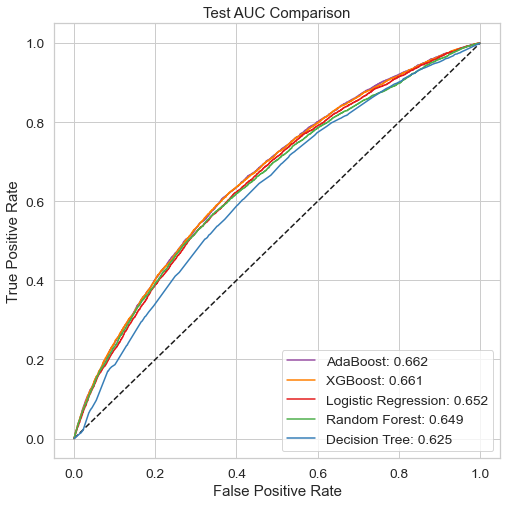

In [27]:
sns.set(rc = {'figure.figsize': (7, 6)},
        font_scale = 1.25) # increase text size on plots (e.g., axis labels)
sns.set_style('whitegrid')

# defining a custom function for reuse later
def Custom_ROC_Plot (results, X_test, y_test, title, figwidth = 8, figheight = 8):

    fig, ax = plt.subplots(figsize = (figwidth, figheight))

    ax.plot(ax.get_xlim(), ax.get_ylim(), ls = '--', c = 'k')
    ax.set(title = title)

    for i in results.index:
        plot_roc_curve(models[i], 
                       X_test, 
                       y_test, 
                       color = cm.Set1(i), 
                       label = results.loc[i, 'Classifier'] + ': {:.3f}'.format(results.loc[i, 'AUC']), 
                       ax = ax)
        
    return([fig, ax])

fig, ax = Custom_ROC_Plot(results, X_test, y_test, title = 'Test AUC Comparison')

Overall these models all perform pretty similarly and are within rounding error of each other. XGBoost or AdaBoost would suit us well, but we will stick with AdaBoost since it has the highest AUC.

### Classification report

Let's now pull out the index of our best model from our results (i.e., the first index from the DataFrame, since it was sorted by descending AUC) and take a closer look at the classification report.

              precision    recall  f1-score   support

          no      0.949     0.607     0.740     56538
         yes      0.123     0.630     0.206      4965

    accuracy                          0.609     61503
   macro avg      0.536     0.618     0.473     61503
weighted avg      0.883     0.609     0.697     61503



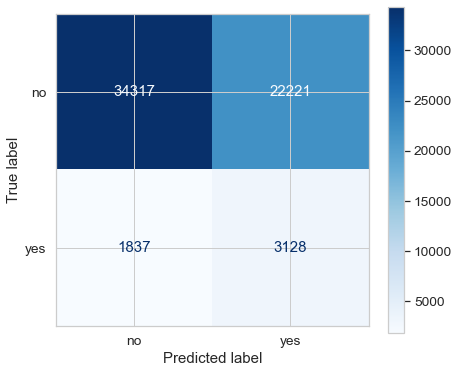

In [28]:
best_index = results.index[0]

plot_confusion_matrix(models[best_index], 
                      X_test, 
                      y_test,
                      cmap = plt.cm.Blues,
                      values_format = 'd')

print(classification_report(y_test, preds[best_index], digits = 3))

The best model did not really perform impressively on the test set with the balanced accuracy of just 61.8% since our original dataset is extremely skewed. There's not enough instances with yes label so the algorithm can learn characteristics of yes label. Model generalization can be improved by collecting more data of yes label.

### Important features 

Given the best model (i.e. AdaBoost), let's explore the top ten important features that have the greatest effect on the target variable (i.e. customer default)

<AxesSubplot:xlabel='importance', ylabel='feature'>

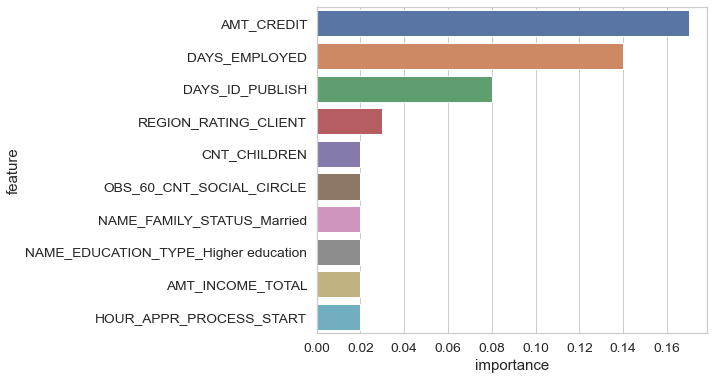

In [29]:
var_imp = pd.DataFrame({'feature': X_test.columns, 
                        'importance': models[best_index].best_estimator_.feature_importances_}).sort_values('importance', ascending = False)

sns.barplot(y = 'feature', 
            x = 'importance', 
            data = var_imp.head(10))

Out of ten features, the three most important ones are `AMT_CREDIT`, `DAYS_EMPLOYED`, `DAYS_ID_PUBLISH`. This means that amount of credit, number of days before loan application the customer start her/his current job, and number of days before loan application the customer change the identity documents have the biggest effect on the probability of customer default.

---

## 5. Conclusion

- This project aims to develop a predictive model that predicts if a customer will default. The data set for model training and evaluation consists of 26 variables and 307,511 samples. Each sample represents a customer and each variable represents a feature about customer. The target variable is the binary variable `TARGET` with two values: yes indicates that the customer defaults and no indicates that the customer does not. The other 25 variables are all predictors, including customer data (gender, family, job, martial, education, etc.), and loan application data (contact type, amount of credit,…).

- This is a classification problem. We first conduct descriptive analysis to get a sense of relationships between target variable and predictors. However, in order to take into account interaction of predictors, we need to build machine learning models. Prior to developing a model, we need to conduct data preprocessing, including splitting the data set into train/test set, downsizing the train set to make class balance, imputing missing data, converting categorical variables into dummy variables, removing features with zero variance, and scaling the data.

- 5 different machine learning models were built for this analysis: Logistic Regression, Decision Tree, Random Forest, AdaBoost, and XGBoost. AdaBoost outperforms other models based on AUC and the classification that this AdaBoost model can correctly predict 61% of samples in the test set.

- Three most important features in predicting target variable are amount of credit, number of days before loan application the customer start her/his current job, and number of days before loan application the customer change the identity documents. From a business standpoint, the importance of those 3 variables in this prediction is intuitive. 

- Amount of credit obviously plays an important role in the probability of default: the higher amount of credit compared to income, the more likely a customer will default. Importance of number of days before loan application the customer start her/his current job can be explained that the shorter the recent employment is, the lower saving a customer has and thus is more likely to default. Number of days before loan application the customer change the identity documents reflects the credibility of a customer.

- This analysis provides a model that can be leveraged to predict if a particular client will default based on her/his features. With that prediction, the bank/credit card company can decide on approving a certain loan application and also take appropriate actions in time to prevent their loss due to customer default, boosting the bottom line going forward.

---